In [1]:
import logging

import data_utils as du
import evaluation as ev
from naive_bayes import NaiveBayesClassifier
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


In [2]:
NEG_FILE_LIST = du.load_data('NEG')
POS_FILE_LIST = du.load_data('POS')

neg_train_data = NEG_FILE_LIST[:900]
neg_test_data = NEG_FILE_LIST[900:]

pos_train_data = POS_FILE_LIST[:900]
pos_test_data = POS_FILE_LIST[900:]

training_data = {"pos": pos_train_data, "neg": neg_train_data}
test_data = neg_test_data + pos_test_data
test_targets = [0 for _ in range(len(neg_test_data))] +  [1 for _ in range(len(pos_test_data))]
test_targets[:2] + test_targets[100:102]

INFO:data_utils:Successfully read 1000 NEG files
INFO:data_utils:Successfully read 1000 POS files


[0, 0, 1, 1]

In [3]:
def eval_nb(training_data, test_data, models, smoothing=0):
    nb = NaiveBayesClassifier(models=models, smoothing=smoothing)
    nb.train_naive_bayes(training_data)
    
    return nb.predict(test_data)
    

## Unsmoothed model

In [4]:
predictions = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=0)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4)], smoothing=0
INFO:naive_bayes:Counting occurences for model with n=1, cutoff=4
INFO:naive_bayes:Counting occurences for model with n=1, cutoff=4
INFO:naive_bayes:Computed vocab size 13718


0.825

In [5]:
predictions = eval_nb(training_data, test_data, models=[(2, 7)], smoothing=0)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(2, 7)], smoothing=0
INFO:naive_bayes:Counting occurences for model with n=2, cutoff=7
INFO:naive_bayes:Counting occurences for model with n=2, cutoff=7
INFO:naive_bayes:Computed vocab size 16479


0.76

In [6]:
predictions = eval_nb(training_data, test_data, models=[(1, 4), (2, 7)], smoothing=0)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4), (2, 7)], smoothing=0
INFO:naive_bayes:Counting occurences for model with n=1, cutoff=4
INFO:naive_bayes:Counting occurences for model with n=2, cutoff=7
INFO:naive_bayes:Counting occurences for model with n=1, cutoff=4
INFO:naive_bayes:Counting occurences for model with n=2, cutoff=7
INFO:naive_bayes:Computed vocab size 30197


0.81

## Smoothed model

In [22]:
predictions = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=0.1)
np.mean(predictions == test_targets)

0.8

In [21]:
predictions = eval_nb(training_data, test_data, models=[(2, 7)], smoothing=0.1)
np.mean(predictions == test_targets)

0.835

In [9]:
predictions = eval_nb(training_data, test_data, models=[(1, 4), (2, 7)], smoothing=1)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4), (2, 7)], smoothing=1
INFO:naive_bayes:Counting occurences for model with n=1, cutoff=4
INFO:naive_bayes:Counting occurences for model with n=2, cutoff=7
INFO:naive_bayes:Counting occurences for model with n=1, cutoff=4
INFO:naive_bayes:Counting occurences for model with n=2, cutoff=7
INFO:naive_bayes:Computed vocab size 30197


0.835

In [10]:
# Study how smoothing affects acc
logging.getLogger().setLevel(logging.CRITICAL)

smoothing_accs = []
log_smoothings = np.linspace(-5, 5, 20)
smoothings = np.power(10, log_smoothings)

for smoothing in tqdm(smoothings, "Computing smoothing accuracies"):
    predictions = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=smoothing)
    smoothing_accs.append(np.mean(predictions == test_targets))
smoothing_accs

Computing smoothing accuracies: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


[0.76,
 0.765,
 0.775,
 0.78,
 0.79,
 0.79,
 0.79,
 0.8,
 0.82,
 0.825,
 0.825,
 0.825,
 0.845,
 0.59,
 0.505,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

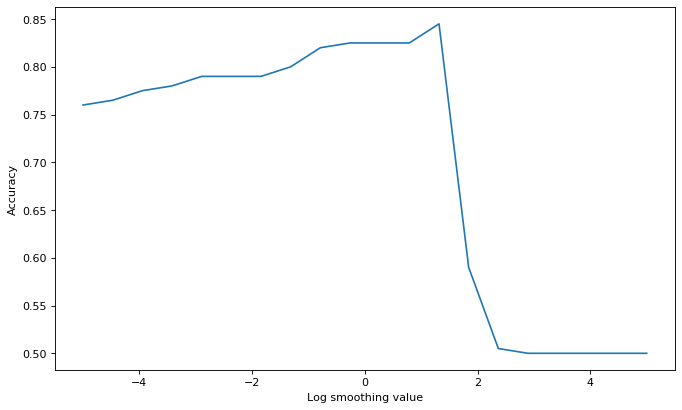

In [11]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(log_smoothings, smoothing_accs)
plt.ylabel('Accuracy')
plt.xlabel('Log smoothing value')
plt.show()

## Compare models

In [13]:
predictionsA = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=0)
predictionsB = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=1)

accA = np.mean(predictionsA == test_targets)
accB = np.mean(predictionsB == test_targets)
p_value = ev.sign_test(predictionsA, predictionsB, test_targets)

print("Model A with accuracy {0} vs model B with accuracy {1} has p-value {2}".format(accA, accB, p_value))

Model A with accuracy 0.825 vs model B with accuracy 0.825 has p-value 1.0563484790092563


In [23]:
model_smooth = [
    ([(1, 4)], 0), ([(1, 4)], 10),
    ([(2, 7)], 0), ([(2, 7)], 1),
    ([(1, 4), (2, 7)], 1), ([(1, 4), (2, 7)], 1)
]
p_vals = np.zeros((6, 6))
accs = np.zeros(6)
for i, (modelA, smoothA) in tqdm(enumerate(model_smooth), "Going over i axis"):
    predictionsA = eval_nb(training_data, test_data, models=modelA, smoothing=smoothA)
    accA = np.mean(predictionsA == test_targets)
    accs[i] = accA
    for j, (modelB, smoothB) in enumerate(model_smooth):
        predictionsB = eval_nb(training_data, test_data, models=modelB, smoothing=smoothB)
        p_value = ev.sign_test(predictionsA, predictionsB, test_targets)
        
        p_vals[i, j] = p_value

print(accs)
print(p_vals)

Going over i axis: 6it [01:27, 14.58s/it]

[0.825 0.845 0.76  0.755 0.835 0.835]
[[1.05634848 0.83207037 0.39501578 0.35800309 0.94365152 0.94365152]
 [0.83207037 1.05634848 0.25665059 0.2292466  0.94365152 0.94365152]
 [0.39501578 0.25665059 1.05634848 1.         0.3209904  0.3209904 ]
 [0.35800309 0.2292466  1.         1.05634848 0.2888205  0.2888205 ]
 [0.94365152 0.94365152 0.3209904  0.2888205  1.05634848 1.05634848]
 [0.94365152 0.94365152 0.3209904  0.2888205  1.05634848 1.05634848]]


## Round Robin


In [ ]:
def get_rr_folds():
    neg_folds = [NEG_FILE_LIST[k::10] for k in range(10)]
    pos_folds = [POS_FILE_LIST[k::10] for k in range(10)]
    return neg_folds, pos_folds


def process_fold_k(neg_folds, pos_folds, k):
    neg_train_data = [file for fold in (neg_folds[:k] + neg_folds[k + 1:]) for file in fold]
    neg_test_data = neg_folds[k]

    pos_train_data = [file for fold in (pos_folds[:k] + pos_folds[k + 1:]) for file in fold]
    pos_test_data = pos_folds[k]

    training_data = {"pos": pos_train_data, "neg": neg_train_data}
    test_data = {"pos": pos_test_data, "neg": neg_test_data}

    return training_data, test_data


def perform_crossvalidation_accuracy(models,  neg_folds, pos_folds, smoothing=0):
    accuracies = []
    correct = []
    for k in range(len(neg_folds)):
        training_data, test_data = process_fold_k(neg_folds=neg_folds, pos_folds=pos_folds, k=k)
        correct_neg, correct_pos = eval_nb(training_data, test_data, models, smoothing)
        accuracy = ev.get_nb_accuracy(correct_neg, correct_pos)
        accuracies.append(accuracy)
        correct.append((sum(correct_neg), sum(correct_pos)))

    return accuracies, correct

In [ ]:
neg_folds, pos_folds = get_rr_folds()

In [ ]:
accuracies, correct = perform_crossvalidation_accuracy(models=[(1, 4)], smoothing=0, neg_folds=neg_folds,
                                                       pos_folds=pos_folds)
print(accuracies)
print(correct)

## Doc2vec

In [ ]:
from doc2vec import get_doc2vec_model
from sklearn.linear_model import SGDClassifier
from gensim.utils import simple_preprocess

from data_utils import load_untagged_data


untagged_files = {cat: load_untagged_data(subdir) for cat, subdir in enumerate(['NEG', 'POS'])}


In [ ]:
def process_files(untagged_files, doc2vec):
    data = list()
    targets = list()
    for cat, cat_files in untagged_files.items():
        for curr_file in tqdm(cat_files, "Processing untagged files".format()):
            data.append(doc2vec.infer_vector(simple_preprocess(curr_file)))
            targets.append(cat)
            
    return data, targets

In [ ]:
doc2vec = get_doc2vec_model()

data, targets = process_files(untagged_files, doc2vec)
print(len(data))
print(np.sum(targets))

In [ ]:
data_folds = [data[k * 100: (k + 1) * 100] + data[1000 + k * 100: 1000 + (k + 1) * 100] for k in range(10)]
target_folds = [targets[k * 100: (k + 1) * 100] + targets[1000 + k * 100: 1000 + (k + 1) * 100] for k in range(10)]

def get_without_k(k, data_folds=data_folds, target_folds=target_folds):
    # Remove fold k and concat rest
    train_data = list()
    train_targets = list()
    for index in range(10):
        if index != k:
            train_data.extend(data_folds[index])
            train_targets.extend(target_folds[index])
    return train_data, train_targets

print(len(data_folds))
print(target_folds[7])

In [ ]:
from sklearn.linear_model import SGDClassifier


svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,  max_iter=5, tol=None)

accs = list()
for k in range(10):
    train_data, train_targets = get_without_k(k)
    svm.fit(train_data, train_targets)
    predicted = svm.predict(data_folds[k])

    accs.append(np.mean(predicted == target_folds[k]))
accs


In [ ]:
def test_doc2vec_model(doc2vec):
        data, targets = process_files(untagged_files, doc2vec)
        data_folds = [data[k * 100: (k + 1) * 100] + data[1000 + k * 100: 1000 + (k + 1) * 100] for k in range(10)]
        target_folds = [targets[k * 100: (k + 1) * 100] + targets[1000 + k * 100: 1000 + (k + 1) * 100] for k in range(10)]
        
        svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,  max_iter=5, tol=None)

        accs = list()
        for k in range(10):
            train_data, train_targets = get_without_k(k, data_folds=data_folds, target_folds=target_folds)
            svm.fit(train_data, train_targets)
            predicted = svm.predict(data_folds[k])

            accs.append(np.mean(predicted == target_folds[k]))
        return accs

In [ ]:

results = dict()

epochs = 10
vector_size = 100
dm_concat = 1
min_count = 2
for dm in [0, 1]:
    for context_window in [2, 4]:
        for hierarchical_softmax in [0, 1]:
            doc2vec = get_doc2vec_model(dm=dm, vector_size=vector_size, context_window=context_window,
                              hierarchical_softmax=hierarchical_softmax, dm_concat=dm_concat, epochs=epochs)
            
            accs = test_doc2vec_model(doc2vec)
            model = "model_{dm}_{vector_size}_{epochs}_{context_window}_{min_count}_{hierarchical_softmax}_{dm_concat}".format(
                dm=bool(dm), vector_size=vector_size, epochs=epochs, context_window=context_window,
                min_count=min_count, hierarchical_softmax=hierarchical_softmax, dm_concat=dm_concat)
            results[model] = accs
            
for model, accs in results.items():
    print("Model {0} got accs \n\t{1}".format(model, accs))